**Downloading the data**



In [1]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -r aclImdb/train/unsup

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  6633k      0  0:00:12  0:00:12 --:--:-- 14.4M


Preparing the data

In [2]:
import os, pathlib, shutil, random
from tensorflow import keras
batchSize = 32
project_base_directory= pathlib.Path("/content/aclImdb")
validation_data_directory = project_base_directory/ "val"
training_data_directory = project_base_directory / "train"
for category in ("neg", "pos"):
    os.makedirs(validation_data_directory / category, exist_ok=True )

    files = os.listdir(training_data_directory / category)
    random.Random(1496).shuffle(files)
    num_val_samples = 10000
    validation_file_list = files[-num_val_samples:]
    for fname in validation_file_list:
        shutil.move(training_data_directory / category / fname,
                    validation_data_directory / category / fname)

training_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batchSize
).take(100)  # Restrict training samples to 100

validation_dataset = keras.utils.text_dataset_from_directory(
    "/content/aclImdb/val", batch_size=batchSize
)
testing_dataset = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batchSize
)
te_only_training_dataset = training_dataset.map(lambda x, y: x)


Found 5000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


Setting up datasets for numeric sequences

**A model that processes sequences represented as one-hot encoded vectors**

In [3]:
from tensorflow.keras import layers

MAX_SEQUENCE_LENGTH = 150
MAX_VOCAB_SIZE = 10000

# Define TextVectorization layer
t_vectorization = layers.TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=MAX_SEQUENCE_LENGTH,
)

# Extract texts only from train_ds for vectorization adaptation
training_text_only_dataset = training_dataset.map(lambda x, y: x)
t_vectorization.adapt(training_text_only_dataset)

# Vectorize the train, validation, and test datasets
int_train_dataset = training_dataset.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_val_dataset = validation_dataset.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)
int_testing_dataset = testing_dataset.map(
    lambda x, y: (t_vectorization(x), y),
    num_parallel_calls=4
)


In [4]:
import tensorflow as tf  # Model with embedding layer

input_layer = keras.Input(shape=(None,), dtype="int64")
embedding_output = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(input_layer)
x = layers.Bidirectional(layers.LSTM(32))(embedding_output)
x = layers.Dropout(0.5)(x)
output_layer = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(input_layer, output_layer)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 64)        │     73,984 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

Beginning with the core principles of sequencing

In [5]:
checkpoint_callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
# Ensure this is run before plotting
history = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5349 - loss: 0.6912 - val_accuracy: 0.5997 - val_loss: 0.6768
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6668 - loss: 0.6216 - val_accuracy: 0.7675 - val_loss: 0.4931
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8043 - loss: 0.4381 - val_accuracy: 0.7957 - val_loss: 0.4504
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.8761 - loss: 0.3185 - val_accuracy: 0.8023 - val_loss: 0.4357
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9141 - loss: 0.2290 - val_accuracy: 0.7990 - val_loss: 0.4599
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9390 - loss: 0.1755 - val_accuracy: 0.7600 - val_loss: 0.5689
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9502 - loss: 0.1329 - val_accuracy: 0.7699 - val_loss: 0.5698
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.9768 - loss: 0.0822 - val_a

In [6]:
model = keras.models.load_model('one_hot_bidir_lstm.keras')
print(f"Test acc: {model.evaluate(int_testing_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7949 - loss: 0.4473
Test acc: 0.793


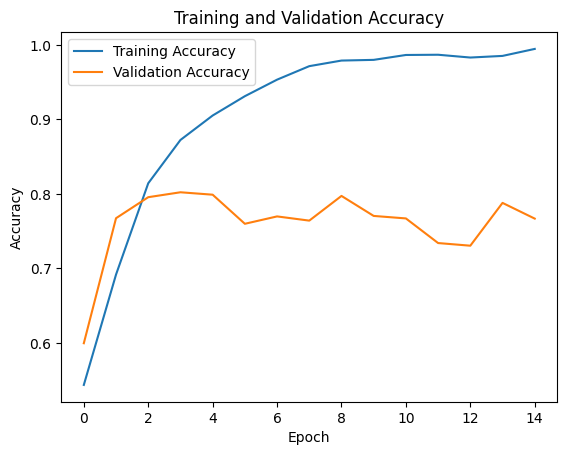

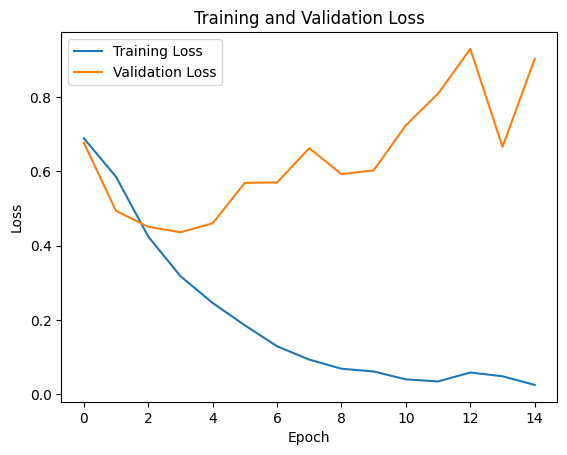

In [8]:

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



# Using the Embedded level to extract embedded words

Using the Embedded level to extract embedded words


In [9]:
em_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)

Anchor layer system developed from the ground up

In [10]:
in1 = keras.Input(shape=(None,), dtype="int64")
em1 = layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=256)(in1)
x = layers.Bidirectional(layers.LSTM(32))(em1)
x = layers.Dropout(0.5)(x)
output_layer1 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in1, output_layer1)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, None, 256)      │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
checkpoint_callbacks1 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru.keras",  # Change to .keras
                                    save_best_only=True)
]

history1 = model.fit(int_train_dataset, validation_data=int_val_dataset, epochs=15, callbacks=checkpoint_callbacks1)

# Load the best model saved by the callback
model = keras.models.load_model("embeddings_bidir_gru.keras")

# Evaluate the model on the test dataset
print(f"Test acc: {model.evaluate(int_testing_dataset)[1]:.3f}")


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.4960 - loss: 0.6929 - val_accuracy: 0.5738 - val_loss: 0.6822
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.6517 - loss: 0.6457 - val_accuracy: 0.7243 - val_loss: 0.5664
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - accuracy: 0.7557 - loss: 0.5115 - val_accuracy: 0.7486 - val_loss: 0.5174
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - accuracy: 0.8392 - loss: 0.3909 - val_accuracy: 0.7559 - val_loss: 0.5270
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.8764 - loss: 0.3175 - val_accuracy: 0.7769 - val_loss: 0.4885
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.9017 - loss: 0.2587 - val_accuracy: 0.7833 - val_loss: 0.4908
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9298 - loss: 0.1904 - val_accuracy: 0.7731 - val_loss: 0.5813
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9553 - loss: 0.1401 - v

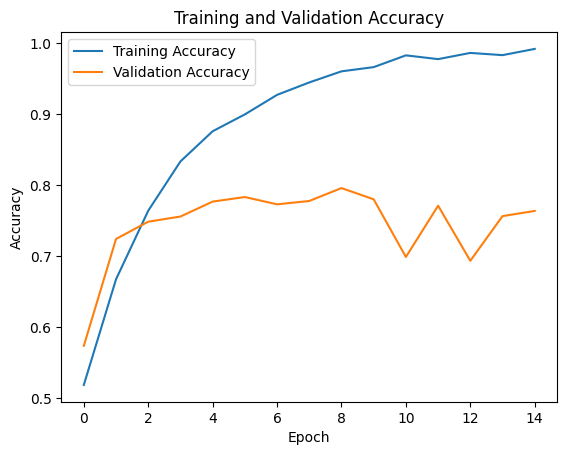

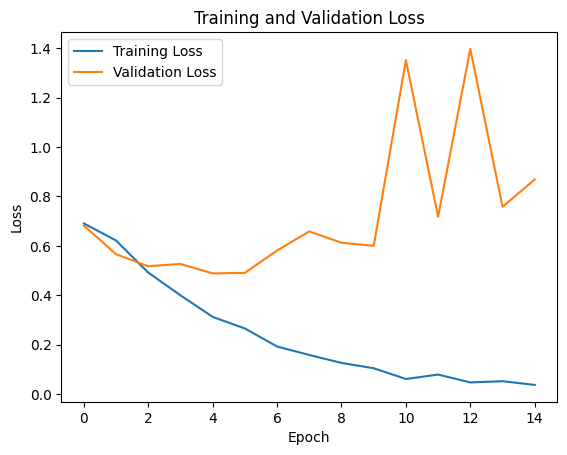

In [13]:
# Visualize training and validation accuracy
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Detecting blur and performing inpainting
Applying filters at the Anchoring level for blur recognition and filling


In [14]:
in2 = keras.Input(shape=(None,), dtype="int64")
em2 = layers.Embedding(
    input_dim=MAX_VOCAB_SIZE, output_dim=256, mask_zero=True)(in2)
x = layers.Bidirectional(layers.LSTM(32))(em2)
x = layers.Dropout(0.5)(x)
output_layer2 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in2, output_layer2)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, None, 256) │  2,560,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, None)      │          0 │ input_layer_2[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 64)        │     73,984 │ embedding_3[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,634,049 (10.05 MB)

 Trainable params: 2,634,049 (10.05 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
checkpoint_callbacks2 = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
history2=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks2)


Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.5147 - loss: 0.6913 - val_accuracy: 0.6054 - val_loss: 0.6787
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6681 - loss: 0.6346 - val_accuracy: 0.7691 - val_loss: 0.5012
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.7847 - loss: 0.4635 - val_accuracy: 0.7571 - val_loss: 0.4936
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.8720 - loss: 0.3204 - val_accuracy: 0.7401 - val_loss: 0.5544
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.9064 - loss: 0.2325 - val_accuracy: 0.7344 - val_loss: 0.6257
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - accuracy: 0.9381 - loss: 0.1766 - val_accuracy: 0.7939 - val_loss: 0.4953
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.9664 - loss: 0.0994 - val_accuracy: 0.7652 - val_loss: 0.6022
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.9776 - loss: 0.0743 - val

In [16]:

model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_testing_dataset)[1]:.3f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.7504 - loss: 0.5039
Test acc: 0.748


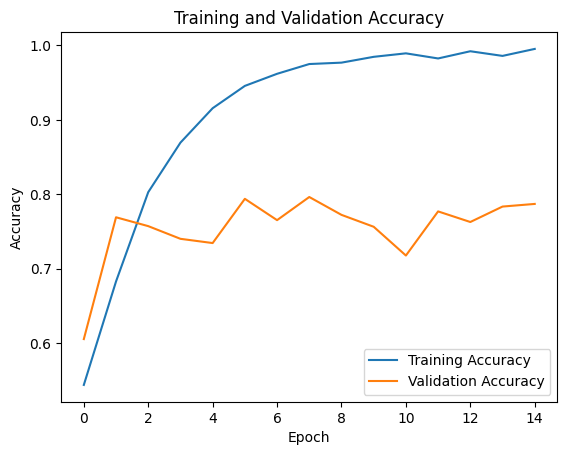

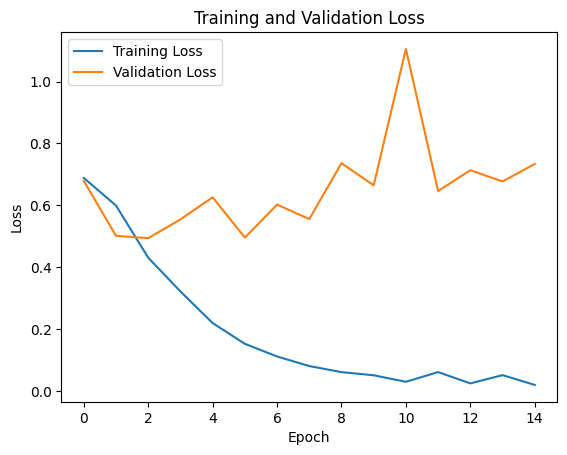

In [18]:
# Plot training and validation accuracy
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Pre-trained word embeddings are utilized

In [19]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2025-11-14 17:37:07--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-11-14 17:37:07--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-11-14 17:37:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Analyzing the word-embeddings package for One

In [20]:
import numpy as np
GLOVE_FILE_PATH = "glove.6B.100d.txt"

glove_embeddings = {}
with open(GLOVE_FILE_PATH) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        glove_embeddings[word] = coefs

print(f"Found {len(glove_embeddings)} word vectors.")

Found 400000 word vectors.


Constructing the matrix for GloVe-embedded words

In [21]:
em_dim = 100

vocab = t_vectorization.get_vocabulary()
word_to_index = dict(zip(vocab, range(len(vocab))))

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, em_dim))
for word, i in word_to_index.items():
    if i < MAX_VOCAB_SIZE:
        em_vector = glove_embeddings.get(word)
    if em_vector is not None:
        embedding_matrix[i] = em_vector

In [22]:
em_layer = layers.Embedding(
    MAX_VOCAB_SIZE,
    em_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

# Architecture incorporating a trained embedded level

In [23]:
in4 = keras.Input(shape=(None,), dtype="int64")
em4 = em_layer(in4)
x = layers.Bidirectional(layers.LSTM(32))(em4)
x = layers.Dropout(0.5)(x)
output_layer4 = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(in4, output_layer4)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 100) │  1,000,000 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ input_layer_3[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 64)        │     34,048 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,034,113 (3.94 MB)

 Trainable params: 34,113 (133.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

In [24]:
checkpoint_callbacks4 = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]

history4=model.fit(int_train_dataset, validation_data= int_val_dataset, epochs=15, callbacks=checkpoint_callbacks4)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test Accuracy: {model.evaluate(int_testing_dataset)[1]:.3f}")

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 99ms/step - accuracy: 0.5161 - loss: 0.7036 - val_accuracy: 0.6075 - val_loss: 0.6601
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.6184 - loss: 0.6550 - val_accuracy: 0.6148 - val_loss: 0.6554
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.6641 - loss: 0.6125 - val_accuracy: 0.7110 - val_loss: 0.5615
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.6832 - loss: 0.5782 - val_accuracy: 0.7308 - val_loss: 0.5426
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.7313 - loss: 0.5306 - val_accuracy: 0.7469 - val_loss: 0.5171
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7474 - loss: 0.5133 - val_accuracy: 0.7556 - val_loss: 0.5062
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 119ms/step - accuracy: 0.7600 - loss: 0.4974 - val_accuracy: 0.6974 - val_loss: 0.5742
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.7751 - loss: 0.47

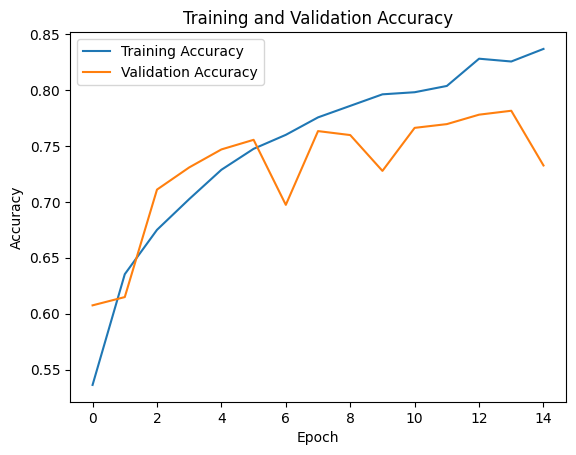

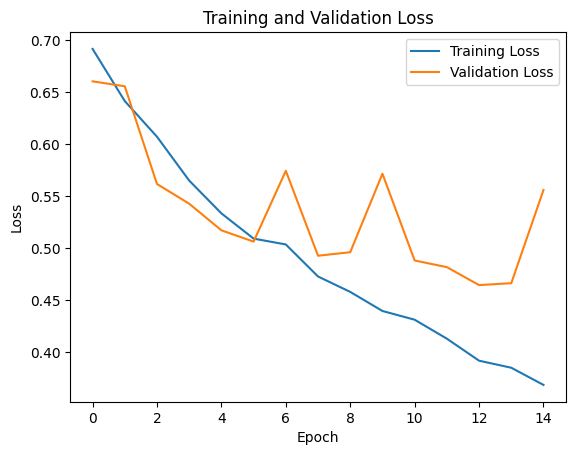

In [25]:
# Visualize training and validation accuracy
plt.plot(history4.history['accuracy'], label='Training Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize training and validation loss
plt.plot(history4.history['loss'], label='Training Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Found 5000 files belonging to 2 classes.
Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.5082 - loss: 0.6934 - val_accuracy: 0.5606 - val_loss: 0.6886
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.6214 - loss: 0.6674 - val_accuracy: 0.7221 - val_loss: 0.5807
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - accuracy: 0.7427 - loss: 0.5511 - val_accuracy: 0.7382 - val_loss: 0.5462
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.8165 - loss: 0.4385 - val_accuracy: 0.7526 - val_loss: 0.5278
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - accuracy: 0.8707 - loss: 0.3359 - val_accuracy: 0.6633 - val_loss: 0.7612
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.8925 - loss: 0.2773 - val_accuracy: 0.7767 - val_loss: 0.4776
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.9404 - loss: 0.1878 - val_accuracy: 0.7912 - val_loss: 0.5001
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - 

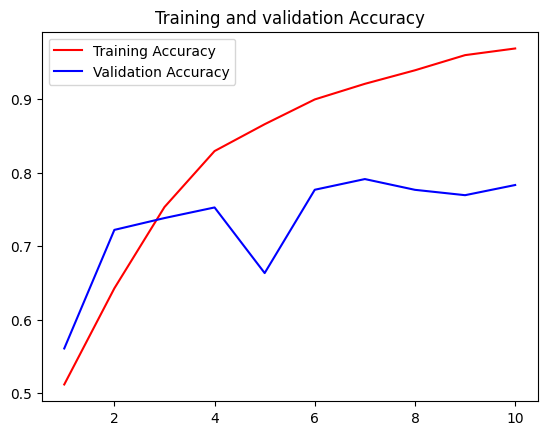

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 105ms/step - accuracy: 0.5543 - loss: 0.6939 - val_accuracy: 0.5905 - val_loss: 0.6668
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.6100 - loss: 0.6495 - val_accuracy: 0.6879 - val_loss: 0.5976
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7005 - loss: 0.5921 - val_accuracy: 0.7292 - val_loss: 0.5446
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7187 - loss: 0.5534 - val_accuracy: 0.7448 - val_loss: 0.5310
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7434 - loss: 0.5119 - val_accuracy: 0.7359 - val_loss: 0.5304
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.7729 - loss: 0.4835 - val_accuracy: 0.7631 - val_loss: 0.5014
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.7751 - loss: 0.4844 - val_accuracy: 0.7710 - val_loss: 0.4838
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.7875 - loss: 0.4557 -

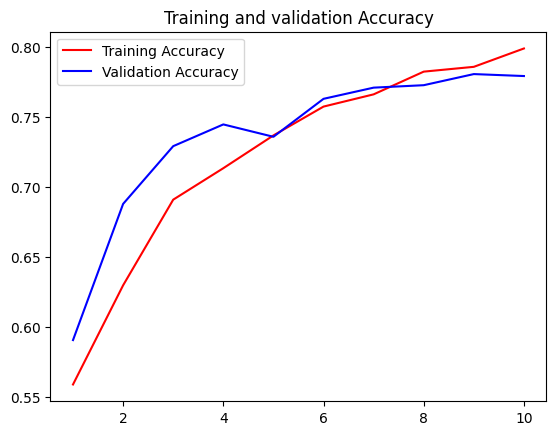

Training samples: 100
Embedding layer test accuracy: 0.761
Pretrained embeddings test accuracy: 0.775
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5305 - loss: 0.6912 - val_accuracy: 0.5709 - val_loss: 0.6669
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - accuracy: 0.6862 - loss: 0.6022 - val_accuracy: 0.5985 - val_loss: 0.6929
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.8082 - loss: 0.4441 - val_accuracy: 0.7545 - val_loss: 0.5043
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8484 - loss: 0.3668 - val_accuracy: 0.7000 - val_loss: 0.8562
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.8945 - loss: 0.2855 - val_accuracy: 0.8128 - val_loss: 0.4420
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.9190 - loss: 0.2227 - val_accuracy: 0.8007 - val_loss: 0.4489
Epoch 7/10
157/157 ━━━━━━━━━━━

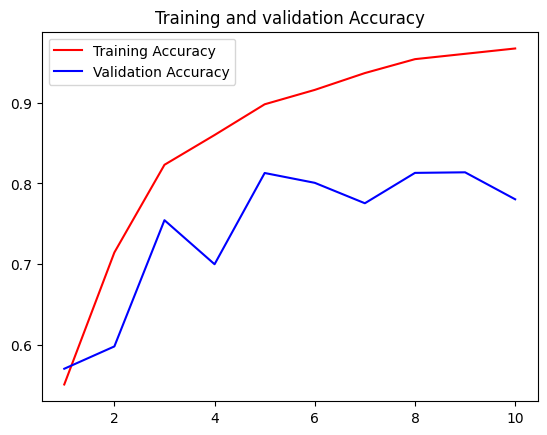

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5496 - loss: 0.6895 - val_accuracy: 0.6528 - val_loss: 0.6233
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.6540 - loss: 0.6187 - val_accuracy: 0.6572 - val_loss: 0.6251
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7108 - loss: 0.5704 - val_accuracy: 0.6647 - val_loss: 0.6004
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7391 - loss: 0.5330 - val_accuracy: 0.7452 - val_loss: 0.5155
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - accuracy: 0.7670 - loss: 0.4920 - val_accuracy: 0.7746 - val_loss: 0.4794
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.7873 - loss: 0.4680 - val_accuracy: 0.7220 - val_loss: 0.5462
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 61ms/step - accuracy: 0.8054 - loss: 0.4390 - val_accuracy: 0.7864 - val_loss: 0.4536
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.7976 - loss: 0.4388 - val

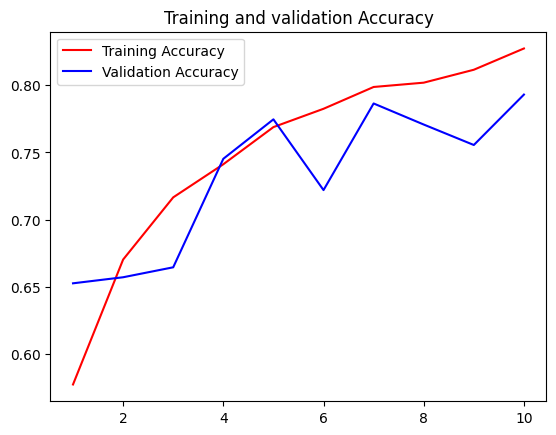

Training samples: 500
Embedding layer test accuracy: 0.803
Pretrained embeddings test accuracy: 0.788
--------------------------------------------------
Found 5000 files belonging to 2 classes.
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.5384 - loss: 0.6877 - val_accuracy: 0.7099 - val_loss: 0.5968
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - accuracy: 0.7325 - loss: 0.5529 - val_accuracy: 0.7913 - val_loss: 0.4661
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8156 - loss: 0.4318 - val_accuracy: 0.8103 - val_loss: 0.4421
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step - accuracy: 0.8735 - loss: 0.3255 - val_accuracy: 0.7997 - val_loss: 0.4510
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.8936 - loss: 0.2894 - val_accuracy: 0.7970 - val_loss: 0.5601
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.9202 - loss: 0.2306 - val_accuracy: 0.8207 - val_loss: 0.4811
Epoch 7/10
157/157 ━━━━━━━━━━

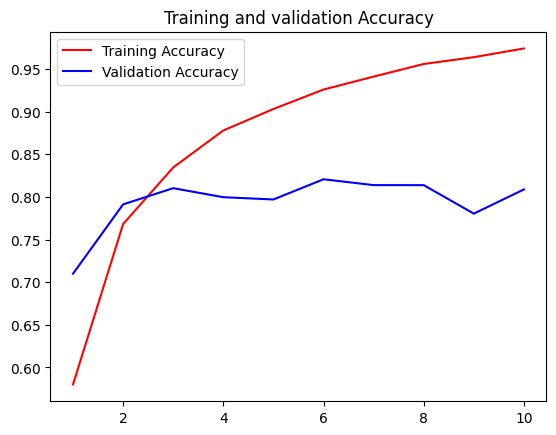

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.5486 - loss: 0.6920 - val_accuracy: 0.6293 - val_loss: 0.6401
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6627 - loss: 0.6093 - val_accuracy: 0.7068 - val_loss: 0.5744
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.7169 - loss: 0.5626 - val_accuracy: 0.7236 - val_loss: 0.5456
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.7403 - loss: 0.5325 - val_accuracy: 0.5980 - val_loss: 0.6832
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7489 - loss: 0.5104 - val_accuracy: 0.7216 - val_loss: 0.5425
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - accuracy: 0.7689 - loss: 0.4762 - val_accuracy: 0.7465 - val_loss: 0.5082
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.7863 - loss: 0.4612 - val_accuracy: 0.7753 - val_loss: 0.4715
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 95ms/step - accuracy: 0.7915 - loss: 0.4427 - v

In [ ]:
training_sample_size_list = [100, 500, 1000, 5000, 10000, 20000]
for train_size in training_sample_size_list:
    training_dataset = keras.utils.text_dataset_from_directory(
        "aclImdb/train", batch_size=batchSize
    ).take(train_size)

    int_training_dataset = training_dataset.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_validation_dataset = validation_dataset.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )
    int_testing_dataset = testing_dataset.map(
        lambda x, y: (t_vectorization(x), y),
        num_parallel_calls=4
    )

    # Train and evaluate the model with the embedding layer
    embedding_layer = layers.Embedding(MAX_VOCAB_SIZE, em_dim)

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_training_dataset, validation_data=int_validation_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("embeddings_model.keras")
    embedding_layer_test_acc = model.evaluate(int_testing_dataset)[1]

    loss = history.history["accuracy"]
    validation_loss_value = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, validation_loss_value, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Train and evaluate the model with the pretrained word embeddings
    embedding_layer = layers.Embedding(
        MAX_VOCAB_SIZE,
        em_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        mask_zero=True,
    )

    inputs = keras.Input(shape=(None,), dtype="int64")
    embedded = embedding_layer(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(embedded)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])

    callbacks = [
        keras.callbacks.ModelCheckpoint("pretrained_embeddings_model.keras", save_best_only=True)
    ]
    history = model.fit(int_training_dataset, validation_data=int_validation_dataset, epochs=10, callbacks=callbacks)
    model = keras.models.load_model("pretrained_embeddings_model.keras")
    pretrained_embeddings_test_acc = model.evaluate(int_testing_dataset)[1]

    loss = history.history["accuracy"]
    validation_loss_value = history.history["val_accuracy"]
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, "r", label="Training Accuracy")
    plt.plot(epochs, validation_loss_value, "b", label="Validation Accuracy")
    plt.title("Training and validation Accuracy")
    plt.legend()
    plt.show()

    # Compare the performance and store the results
    print(f"Training samples: {train_size}")
    print(f"Embedding layer test accuracy: {embedding_layer_test_acc:.3f}")
    print(f"Pretrained embeddings test accuracy: {pretrained_embeddings_test_acc:.3f}")
    print("-" * 50)


